# Prophet 
HDD y CDD como variables predictoras

* https://facebook.github.io/prophet/docs/quick_start.html#python-api

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random
import torch

from statsmodels.graphics.tsaplots import plot_pacf

from data   import standarizer, \
                   features_target_split, \
                   train_test_split

from data   import train_test_split

import pytorch_common.util    as pu
from prophet import Prophet

## Setup

In [178]:
DATASET_PATH = 'https://raw.githubusercontent.com/magistery-tps/time-series-tp/master/datasets/consumo_energetico_diario.csv'
dataset = pd.read_csv(DATASET_PATH,parse_dates=['dia'])
dataset.columns = dataset.columns.str.lower()

dataset.rename(columns={'dia':'ds','mwh':'y'},inplace=True)

dataset.head()

,ds,y,tmp
0,2005-12-01,81445.928,18.104167
1,2005-12-02,81749.888,17.904167
2,2005-12-03,72134.590,19.562500
3,2005-12-04,63452.628,18.854167
4,2005-12-05,81508.078,21.941667


In [179]:
path ='https://raw.githubusercontent.com/magistery-tps/time-series-tp/master/datasets/Temperatura_lon_-58.2813_lat_-34.8115.csv'
temp_cd_hd = pd.read_csv(path,parse_dates=['Fecha'])
temp_cd_hd.columns = temp_cd_hd.columns.str.lower()

temp_cd_hd.rename(columns={'fecha':'ds'},inplace=True)
temp_cd_hd.drop(columns=['unnamed: 0'],inplace=True)

temp_cd_hd.head()

,ds,t_mean,t_max,t_min,longitud,latitud
0,2005-01-01,28.12,35.50,20.43,-58.2813,-34.8115
1,2005-01-02,27.43,33.73,22.65,-58.2813,-34.8115
2,2005-01-03,28.12,32.94,21.48,-58.2813,-34.8115
3,2005-01-04,27.90,35.66,21.22,-58.2813,-34.8115
4,2005-01-05,28.44,35.71,21.35,-58.2813,-34.8115


## Functions

In [180]:
def predict(model, y_true_df, times):
    sns.set(rc = {'figure.figsize':(10,6)})

    y_true_df = y_true_df.head(times)

    y_pred_df = model.predict(y_true_df[['ds']])

    predictions_df = y_true_df.merge(y_pred_df, on='ds')
    predictions_df = predictions_df[['ds', 'y', 'yhat']]
    predictions_df = predictions_df.sort_values(by='ds',ascending=True)
    
    plot(
        predictions_df.yhat.values,
        predictions_df.y.values
    )
    model.plot(y_pred_df)

## Preprocessing

In [181]:
train_set, test_set = train_test_split(dataset,0.10095)
N_test=len(test_set)

Acoto desde 2012 en adelante ya que las oscilaciones se ven de amplitud mas constante. Al observar los años 2006-2011 parecen ir creciendo la tendencia de consumo de energía.

In [182]:
train_set=train_set[train_set.ds>'12-31-2011'] #ultimo dia train 31/12/2019
train_set.reset_index(inplace=True)

### Cooling & heating degree

The calculation requires daily measurements of maximum and minimum outside air temperatures ( Tmax and Tmin ) and a 'base temperature' Tbase, nominated by the user as an estimate of the outside air temperature at which no artificial heating (or cooling) is required. In the UK Tbase for heating has commonly been set at 15.5°C (*), but other base temperatures can be adopted.

- degree day heating HDD
- degree day cooling CDD

Referencia general:
http://www.vesma.com/ddd/ddcalcs.htm

otras ref: https://www.e-education.psu.edu/egee102/node/2055

(*) usualmente t_base=65°F=18°C 
https://www.investopedia.com/terms/h/heatingdegreeday.asp

Referencia de Argentina:
https://repositoriosdigitales.mincyt.gob.ar/vufind/Record/SEDICI_3dc5812eca4a6d54f3edad5e0497f097

Elijo 18°C. Se pueden probar otros valores.

In [183]:
#http://www.vesma.com/ddd/ddcalcs.htm
def heating_fun(t_base,t_max,t_min):
    if (t_min>t_base):
        dh=0
    elif ((t_max+t_min)/2>t_base):
        dh=(t_base-t_min)/4
    elif (t_max>=t_base):
        dh=(t_base-t_min)/2-(t_max-t_base)/4
    else:#(t_max<t_base):
        dh=t_base-(t_max+t_min)/2   
    return dh

def cooling_fun(t_base,t_max,t_min):
    if (t_max<t_base):
        dc=0
    elif ((t_max+t_min)/2<t_base):
        dc=(t_max-t_base)/4
    elif (t_min<=t_base):
        dc=(t_max-t_base)/2-(t_base-t_min)/4
    else:# (t_min>t_base):
        dc=(t_max+t_min)/2-t_base
    return dc

In [184]:
tinvierno=18 #estos valores se pueden cambiar 
tverano=18

In [185]:
temp_cd_hd['date'] = pd.to_datetime(temp_cd_hd['ds'])
temp_cd_hd['day_year'] = temp_cd_hd['date'].dt.dayofyear 
bins = [0, 91, 183, 275, 366]  #estaciones
labels=['verano', 'otoño','invierno', 'primavera'] #hemisferio sur
doy = temp_cd_hd.day_year
temp_cd_hd['season'] = pd.cut(doy + 11 - 366*(doy > 355), bins=bins, labels=labels)
temp_cd_hd.reset_index(inplace=True)

temp_cd_hd['t_base']=temp_cd_hd['season'].apply(lambda x: tverano if x in ('verano', 'primavera') else tinvierno)

temp_cd_hd['cooling_day']=temp_cd_hd.apply(lambda x: cooling_fun(x.t_base, x.t_max,x.t_min) if x.season in ('verano', 'primavera') else 0, axis=1)
temp_cd_hd['heating_day']=temp_cd_hd.apply(lambda x: heating_fun(x.t_base, x.t_max,x.t_min) if x.season in ('otoño', 'invierno') else 0, axis=1)
#temp_cd_hd['heating_day']=temp_cd_hd.apply(lambda x: heating_fun(x.t_base, x.t_max,x.t_min), axis=1)

In [186]:
temperatura = pd.DataFrame(temp_cd_hd[['ds','heating_day','cooling_day']])
temperatura=temperatura[(temperatura.ds>='2012-01-01')&(temperatura.ds<='2021-07-31')]
temperatura.reset_index(inplace=True)

train_set=pd.merge(train_set,temperatura, how='left',on='ds')

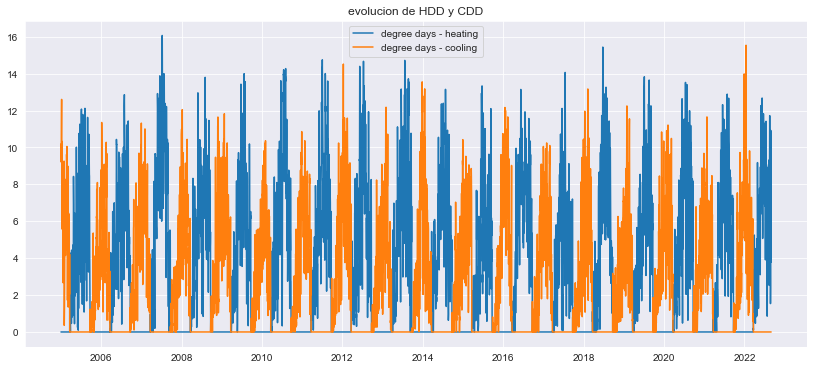

In [188]:
plt.figure(figsize=(14, 6))
sns.set_style("darkgrid")
plt.plot(temp_cd_hd.ds,temp_cd_hd.heating_day,label='degree days - heating')
#plt.plot(temp_cd_hd.ds,temp_cd_hd.t_mean,label='tmin')
plt.plot(temp_cd_hd.ds,temp_cd_hd.cooling_day,label='degree days - cooling')
plt.title('evolucion de HDD y CDD')
plt.legend()

## Model

In [219]:
model = Prophet() #mcmc_samples=300 #full bayesian
model.add_regressor('heating_day',mode='additive')
model.add_regressor('cooling_day',mode='additive')
#model.add_country_holidays(country_name='Argentina')

model.fit(train_set)

00:24:06 - cmdstanpy - INFO - Chain [1] start processing
00:24:06 - cmdstanpy - INFO - Chain [1] done processing


In [115]:
#model.train_holiday_names

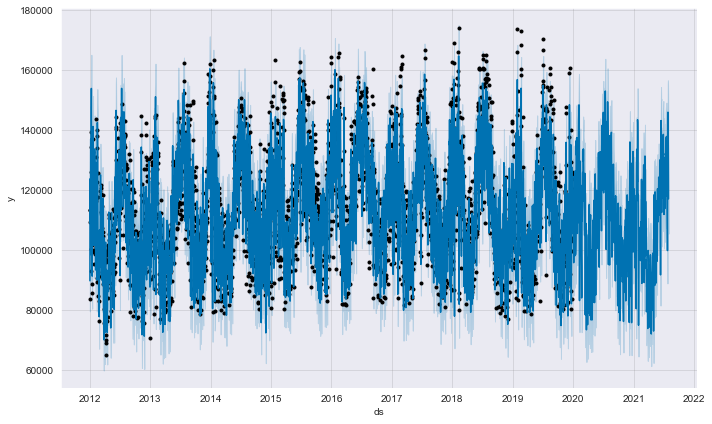

In [220]:
future = model.make_future_dataframe(periods=N_test)
future['heating_day']=temperatura.heating_day
future['cooling_day']=temperatura.cooling_day

forecast = model.predict(future)
fig=model.plot(forecast)

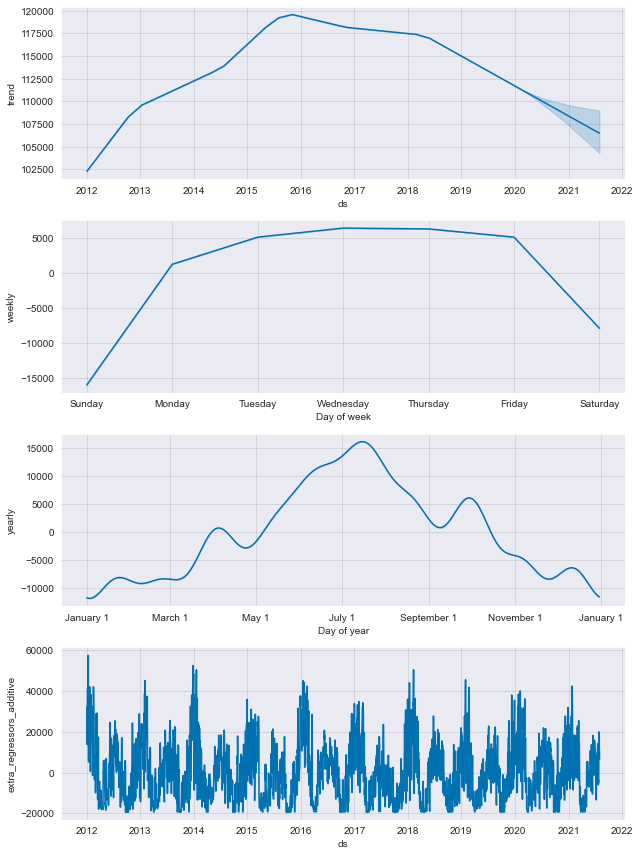

In [221]:
fig=model.plot_components(forecast)

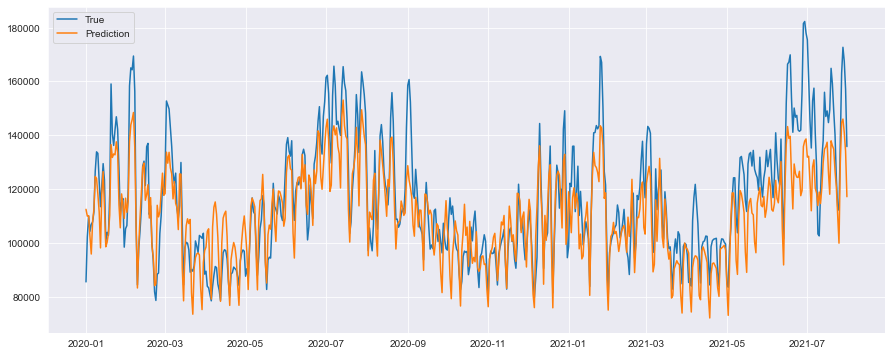

In [222]:
N=len(forecast)
y_fore=forecast['yhat']
y_fore_future=pd.DataFrame(y_fore[-N_test:])
y_fore_train=pd.DataFrame(y_fore[0:N-N_test])


plt.figure(figsize=(15, 6))
sns.set_style("darkgrid")
plt.plot(test_set.ds,test_set.y,label="True")
plt.plot(test_set.ds,y_fore_future, label="Prediction")
plt.legend()

In [223]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   ds                               3500 non-null   datetime64[ns]
 1   trend                            3500 non-null   float64       
 2   yhat_lower                       3500 non-null   float64       
 3   yhat_upper                       3500 non-null   float64       
 4   trend_lower                      3500 non-null   float64       
 5   trend_upper                      3500 non-null   float64       
 6   additive_terms                   3500 non-null   float64       
 7   additive_terms_lower             3500 non-null   float64       
 8   additive_terms_upper             3500 non-null   float64       
 9   cooling_day                      3500 non-null   float64       
 10  cooling_day_lower                3500 non-null   float64    